In [2]:
from qcportal import PortalClient
from qcelemental.models.results import WavefunctionProtocolEnum
from openff.qcsubmit.results import OptimizationResultCollection,BasicResultCollection
from openff.qcsubmit.datasets import OptimizationDataset
from openff.qcsubmit.factories import OptimizationDatasetFactory
from openff.qcsubmit.common_structures import Metadata, QCSpec
import numpy as np
from openff.toolkit import Molecule
import tqdm
from openff.toolkit.utils import OpenEyeToolkitWrapper, ToolkitRegistry
from openff.units import unit
import itertools
import multiprocess

In [3]:
client = PortalClient("https://api.qcarchive.molssi.org:443/")

# Generate conformers (part 2 only)

In [4]:
mlpepper_results = BasicResultCollection.parse_file('mlpepper.json')

In [ ]:
mlpepper_results = BasicResultCollection.from_server(client=client, datasets=['MLPepper RECAP Optimized Fragments v1.0','MLPepper RECAP Optimized Fragments v1.0 Add Iodines'],spec_name='wb97x-d/def2-tzvpp')

`mlpepper.json` was created in the Dataset part 1 notebook. It can be downloaded with the above command.

In [5]:
mlpepper_results.n_molecules

56346

In [6]:
mlpepper_cmiles = np.unique([result.cmiles for result in mlpepper_results.entries['https://api.qcarchive.molssi.org:443/']])

In [7]:
def generate_conformers_pool_lg(inputs) -> Molecule:
    '''
    Function to generate conformers from a CMILES string. Taken from Lily's NAGL2 code.
    Modified to only run for molecules > 300 Da, because conformer generation takes a long time

    inputs should be a list of:
    cmiles: CMILES string to use
    max_conf_elf: maximum number of conformers to keep during the ELF process 
    elf_perc: Percentage of conformers to select from for the ELF process
    n_conf_start: initial number of conformers to generate, to use later for ELF selection
    rms_cut: RMS cutoff for conformer generation
    '''
    cmiles, max_conf_elf, elf_perc, n_conf_start, rms_cut=inputs
    wrapper = OpenEyeToolkitWrapper()
    
    try:
        mol = Molecule.from_mapped_smiles(
            cmiles,
            allow_undefined_stereo=True,
            toolkit_registry=wrapper,
        )
        if sum([atom.mass.m for atom in mol.atoms]) > 300:
            # generate max 1000 conformers with OpenEye
            mol.generate_conformers(
                n_conformers=n_conf_start,
                rms_cutoff=rms_cut * unit.angstrom,
                toolkit_registry=wrapper,
            )
            
            # prune based on ELF method, max 5 conformers output
            mol.apply_elf_conformer_selection(
                percentage=elf_perc,
                limit=max_conf_elf,
                toolkit_registry=wrapper
            )
            
            assert mol.n_conformers > 0
            return (mol,'success')
        else:
            return (mol,'too small')
    except BaseException as e:
        return (mol,e)
    

In [9]:
import itertools
import multiprocess

mols = []
n_confs = []
errs = []
with multiprocess.Pool(8) as pool:
    for ms in tqdm.tqdm(pool.imap(generate_conformers_pool_lg,zip(mlpepper_cmiles,itertools.repeat(5),itertools.repeat(2),itertools.repeat(1000),itertools.repeat(0.1))), desc="generating conformers",total=len(mlpepper_cmiles)):
        mol = ms[0]
        status = ms[1]
        if status == 'success':
            n_confs.append(mol.n_conformers)
            mols.append(mol)
        else:
            if status != 'too small':
                print(status)
                errs.append((mol,status))

generating conformers: 100%|██████████████████████████████████████████████████████████████████████████████| 56346/56346 [02:39<00:00, 354.29it/s]


OpenEye Omega conformer generation failed
OpenEye Omega conformer generation failed


# Analyze conformers (part 2 only)

In [10]:
print(min(n_confs),np.mean(n_confs),np.median(n_confs),max(n_confs))

1 1.940685045948204 1.0 5


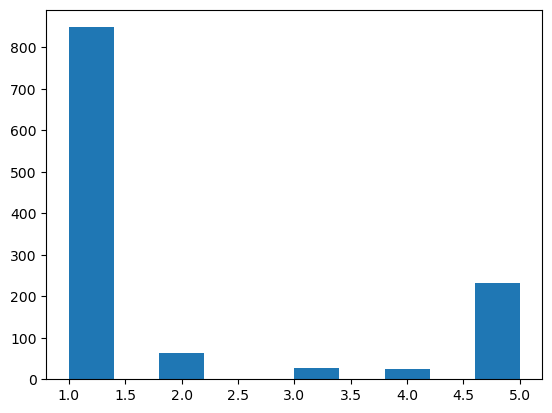

In [11]:
from matplotlib import pyplot as plt
plt.figure()
plt.hist(n_confs)
plt.show()

In [12]:
len(errs)

2

In [13]:
# Would have been better to calculate this during conf gen
all_masses = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in mols
])

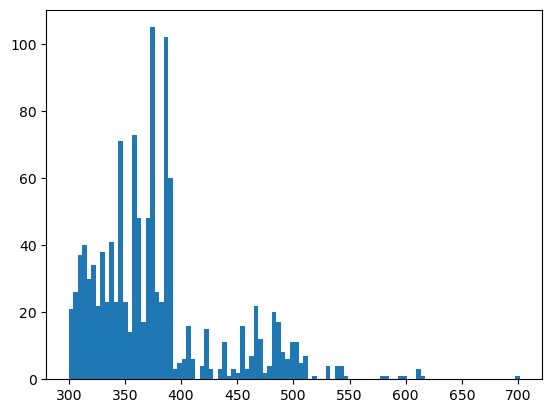

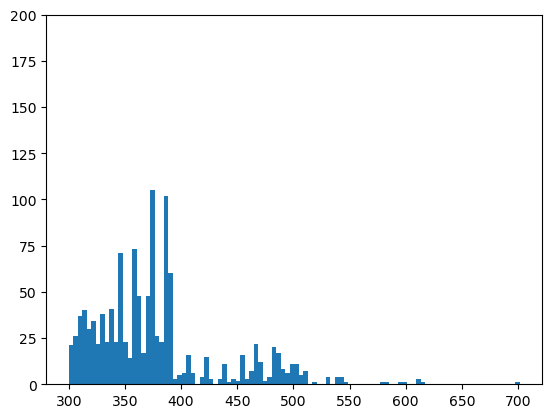

In [14]:
plt.figure()
plt.hist(all_masses,bins=100)

plt.figure()
plt.hist(all_masses,bins=100)
plt.ylim(0,200)
plt.show()

We discussed binning by 300 Da; since there are only a couple of molecules greater than 600 Da I'll leave them in here for now.

In [15]:
print(min(all_masses),np.mean(all_masses),np.median(all_masses),max(all_masses))

300.075338 377.8161830431913 370.917627 701.588756


In [16]:
mols_part1 = []
mols_part2 = []
for mol in tqdm.tqdm(mols):
    if sum([atom.mass.m for atom in mol.atoms]) <= 300:
        mols_part1.append(mol)
    else:
        mols_part2.append(mol)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1197/1197 [00:00<00:00, 25061.81it/s]


# Create dataset

## Part 2-- Molecules > 300 Da

In [17]:
dataset_factory2 = OptimizationDatasetFactory()
provenance2 = dataset_factory2.provenance(ToolkitRegistry([OpenEyeToolkitWrapper]))

In [18]:
dataset2 = OptimizationDataset(
    dataset_name="OpenFF NAGL2 Training Optimization Dataset Part 2 v4.0",
    dataset_tagline="B3LYP-D3BJ/DZVP conformers of diverse fragment molecules with molecular weight greater than 300 Da.",
    description=(
        "A dataset containing molecules from the "
        "`MLPepper RECAP Optimized Fragments v1.0` and `MLPepper RECAP Optimized Fragments v1.0 Add Iodines` "
        "with additional conformers and optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). "
        "The dataset is intended to be used for calculating single point energies and properties, "
        "which will then be used to train our second-generation graph neural network charge model (NAGL2)."
        "This is part 2, for molecules with molecular weight greater than 300 Da.\n\n"
        "For each molecule, a set of up to 5 conformers were generated by:\n"
        "  * generating a set of up to 1000 conformers with a RMS cutoff of 0.1 Å "
        "using the OpenEye backend of the OpenFF toolkit\n"
        "  * applying ELF conformer selection (max 5 conformers) using OpenEye\n\n"
        "Each conformer will be converged according to the 'GAU_LOOSE' criteria."
    ),
    provenance=provenance2
)
dataset2.metadata.submitter = "amcisaac"
dataset2.metadata.long_description_url = (
        "https://github.com/openforcefield/qca-dataset-submission/tree/master/"
        "submissions/"
        "2024-11-19-OpenFF-NAGL2-Training-Optimization-Dataset-Part-2-v4.0"
    )

In [19]:
dataset2._get_specifications()

{'default': OptimizationSpecification(program='geometric', qc_specification=QCSpecification(program='psi4', driver=<SinglepointDriver.deferred: 'deferred'>, method='b3lyp-d3bj', basis='dzvp', keywords={'maxiter': 200, 'scf_properties': [<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>, <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>, <SCFProperties.MayerIndices: 'mayer_indices'>]}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>)), keywords={'coordsys': 'dlc', 'enforce': 0.0, 'epsilon': 1e-05, 'reset': True, 'qccnv': False, 'molcnv': False, 'check': 0, 'trust': 0.1, 'tmax': 0.3, 'maxiter': 300, 'convergence_set': 'GAU'}, protocols=OptimizationProtocols(trajectory=<TrajectoryProtocolEnum.all: 'all'>))}

In [20]:
for mol in tqdm.tqdm(mols_part2):
    dataset2.add_molecule(
        dataset_factory2.create_index(molecule=mol),
        mol
        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1197/1197 [00:22<00:00, 53.33it/s]


## Dataset info

In [22]:
n_confs2 = np.array(
    [mol.n_conformers for mol in dataset2.molecules]
)

n_heavy_atoms2 = np.array(
    [mol.to_rdkit().GetNumHeavyAtoms() for mol in dataset2.molecules]
)

masses2 = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in dataset2.molecules
])

unique_charges2 = [str(charge) for charge in sorted(set([
    mol.total_charge.m_as(unit.elementary_charge)
    for mol in dataset2.molecules
]))]

elements2 = set(
    atom.symbol
    for mol in dataset2.molecules
    for atom in mol.atoms
)

In [23]:
from collections import Counter

print("# heavy atoms")
counts2 = Counter(n_heavy_atoms2)
for n_heavy in sorted(counts2):
    print(f"{str(n_heavy):>3}: {counts2[n_heavy]}")

# heavy atoms
  4: 1
  5: 4
  6: 20
  7: 38
  8: 83
  9: 159
 10: 218
 11: 288
 12: 343
 14: 6
 16: 13
 17: 3
 18: 3
 19: 1
 20: 2
 21: 1
 22: 2
 23: 9
 24: 1
 29: 2


In [24]:
print('* Name: {}'.format(dataset2.dataset_name))
print('* Number of unique molecules: {}'.format(dataset2.n_molecules))
print('* Number of conformers: {}'.format(dataset2.n_records))
print('* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(n_confs2),np.mean(n_confs2),max(n_confs2)))
print('* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(masses2),np.mean(masses2),max(masses2)))
print('* Charges: {}'.format(' '.join(unique_charges2)))

* Name: OpenFF NAGL2 Training Optimization Dataset Part 2 v4.0
* Number of unique molecules: 1197
* Number of conformers: 2323
* Number of conformers (min, mean, max): 1.00, 1.94, 5.00
* Molecular weight (min, mean, max): 300.08, 377.82, 701.59
* Charges: -4.0 -2.0 -1.0 0.0 1.0 2.0


In [25]:
print("## Metadata")
print(f"* Elements: {{{', '.join(dataset2.metadata.dict()['elements'])}}}")

def print_field(od, field): print(f"  * {field}: {od[field]}")

fields = ["basis", "implicit_solvent", "keywords", "maxiter", "method", "program"]
for spec, obj in dataset2.qc_specifications.items():
    od = obj.dict()
    print("* Spec:", spec)
    for field in fields:
        print_field(od, field)
    print("  * SCF properties:")
    for field in od["scf_properties"]:
        print(f"    * {field}")

## Metadata
* Elements: {Si, B, O, I, S, Cl, N, H, C, P, F, Br}
* Spec: default
  * basis: DZVP
  * implicit_solvent: None
  * keywords: {}
  * maxiter: 200
  * method: B3LYP-D3BJ
  * program: psi4
  * SCF properties:
    * dipole
    * quadrupole
    * wiberg_lowdin_indices
    * mayer_indices


## Exporting dataset

Update description to comply with standards

In [27]:
dataset2.metadata.long_description=(("A dataset containing molecules from the "
        "`MLPepper RECAP Optimized Fragments v1.0` and `MLPepper RECAP Optimized Fragments v1.0 Add Iodines` "
        "with additional conformers and optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). "
        "The dataset is intended to be used for calculating single point energies and properties, "
        "which will then be used to train our second-generation graph neural network charge model (NAGL2)."
        "This is part 2, for molecules with molecular weight greater than 300 Da.\n\n"
        "For each molecule, a set of up to 5 conformers were generated by:\n"
        "  * generating a set of up to 1000 conformers with a RMS cutoff of 0.1 Å "
        "using the OpenEye backend of the OpenFF toolkit\n"
        "  * applying ELF conformer selection (max 5 conformers) using OpenEye\n\n"
        "Dataset information:\n"
        "* Number of unique molecules: {}\n"
        "* Number of conformers: {}\n"
        "* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Charges: {}".format(dataset2.n_molecules,dataset2.n_records,min(n_confs2),np.mean(n_confs2),max(n_confs2),min(masses2),np.mean(masses2),max(masses2),' '.join(unique_charges2))
        ))

In [29]:
print(dataset2.metadata.long_description)

A dataset containing molecules from the `MLPepper RECAP Optimized Fragments v1.0` and `MLPepper RECAP Optimized Fragments v1.0 Add Iodines` with additional conformers and optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). The dataset is intended to be used for calculating single point energies and properties, which will then be used to train our second-generation graph neural network charge model (NAGL2).This is part 2, for molecules with molecular weight greater than 300 Da.

For each molecule, a set of up to 5 conformers were generated by:
  * generating a set of up to 1000 conformers with a RMS cutoff of 0.1 Å using the OpenEye backend of the OpenFF toolkit
  * applying ELF conformer selection (max 5 conformers) using OpenEye

Dataset information:
* Number of unique molecules: 1197
* Number of conformers: 2323
* Number of conformers (min, mean, max): 1.00, 1.94, 5.00
* Molecular weight (min, mean, max): 300.08, 377.82, 701.59
* Charges: -4.0 -2.0 -1.0 0.0 1.0 2.0


In [30]:
dataset2.export_dataset("dataset_part2.json.bz2")
dataset2.molecules_to_file('dataset_part2.smi', 'smi')
dataset2.visualize("dataset_part2.pdf", columns=8)